In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Change the path for the file mnist.npz !

5


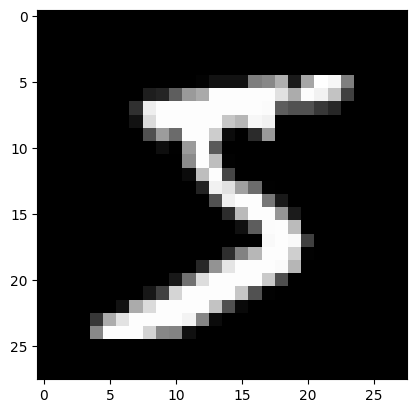

In [4]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="./mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]

x_test = test_data[0].reshape(-1,784).astype(float) / 255
y_test = test_data[1]

print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

In [5]:
# source: https://keras.io/guides/training_with_built_in_methods/

inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
x = layers.Dense(32, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation=None, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#def loss(true, pred):
#    val = 0.
#    for i in range(len(true)):
#        val -= np.log(pred[i, true[i]])
#    return val / len(true)
model.summary()

2024-01-02 18:37:39.936645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-02 18:37:39.938082: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


In [6]:
# untrained model
logits = model(x_train)
np.argmax(logits, 1)[0:100] #predictions on the first 100 images

array([1, 5, 3, 3, 3, 3, 6, 1, 0, 6, 6, 3, 3, 6, 5, 3, 6, 3, 6, 8, 3, 5,
       6, 3, 8, 3, 3, 3, 3, 8, 3, 6, 6, 6, 5, 6, 5, 5, 6, 6, 7, 3, 3, 6,
       3, 3, 3, 3, 3, 5, 5, 1, 3, 6, 3, 3, 3, 1, 3, 3, 3, 3, 5, 2, 5, 6,
       6, 5, 3, 3, 5, 5, 5, 6, 3, 1, 3, 3, 6, 6, 2, 5, 2, 6, 3, 3, 3, 2,
       3, 4, 6, 5, 3, 5, 7, 5, 3, 3, 6, 6])

x_train contains $n=60000$ rows of $p=784$ elements each corresponding to the greyscale of a pixel of a 28 x 28 image. 
logits contains the outputs of the last layer after passing the x_train input through the network. These outputs correspond in some way to probabilities of doing the right estimation for each image passed through the network. This means that the output is a vector of size 10 (corresponding to the 10 digits) containing for each digit a value corresponding to the probability (according to the model) that the image is that digit.
We then pick the biggest probability.

In [7]:
# what we would like to get
y_train[0:100]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

When we compare the two we see that our untrained model estimates extremely poorly, we do note that the parameters are not all set to 0 in the raw version of the model.

In [8]:
## Computing a stochastic gradient

# Source: https://keras.io/guides/writing_a_training_loop_from_scratch/

# Example of gradient computation using automatic differentiation

x_train_batch = x_train[:8]
y_train_batch = y_train[:8]
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        logits = model(x_train_batch)  # Logits for this minibatch

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

## Updating weights

def update_weights(model, update):
    new_weights = model.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + update[i]
    model.set_weights(new_weights)


## Evaluate model
samples_for_evaluation = np.random.randint(0, 10000, 1000)
logits = model(x_train[samples_for_evaluation])
loss(y_train[samples_for_evaluation], logits).numpy()
    

2.3458085

## Question 4.1
A dense layer is a layer such that each neuron of a layer is connected to each neuron of the next.
Thanks to model.summary() we get that there are 26,506 parameters to train.

# Stochastic gradient descent

The randomness comes from the random samples we pick at every step.

## Question 5.1 and 6.1

In [9]:
# Stochastic gradient algorithm

# TO IMPLEMENT

def stochastic_descent(model, epoch, batchsize = 64):
    a = 1
    losses = []
    for k in range(1, epoch * len(x_train) // batchsize):
        gamma = a / (k**0.5)
        samples = np.random.randint(0, len(x_train), batchsize)
        x_train_batch = x_train[samples]
        y_train_batch = y_train[samples]
        with tf.GradientTape() as tape:
            logits = model(x_train_batch)
            loss_value = loss(y_train_batch, logits)
            grad = tape.gradient(loss_value, model.trainable_weights)
            update_weights(model, [-gamma * x for x in grad])

        if k%100 == 0 :
            samples_for_evaluation = np.random.randint(0, 10000, 1000)
            logits = model(x_train[samples_for_evaluation])
            losses.append(loss(y_train[samples_for_evaluation], logits).numpy())
    return losses

In [10]:
Losses = stochastic_descent(model, 10, 64)

In [11]:
print("The final loss is : {}".format(Losses[-1]))

The final loss is : 0.13960884511470795


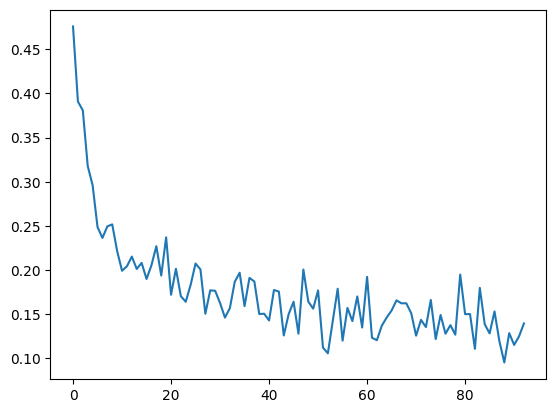

In [12]:
plt.plot(Losses)

In [13]:
# trained model
logits = model(x_test)
np.argmax(logits, 1)[0:100] #predictions on the first 100 images

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 0, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
       2, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9])

In [14]:
# what we would like to get
y_test[0:100]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
       6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9], dtype=uint8)